<a href="https://youtu.be/qkTkVv7m-2w" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>

# Práctico Content-based (Imágenes)

Profesor: Denis Parra

Ayudantes: Vladimir Araujo, Andrés Carvallo, Manuel Cartagena, Francisca Catán, Andres Villa 

Agradecimientos: Pablo Messina

En este proyecto trabajaremos con un modelo de [recomendación de arte](http://dparra.sitios.ing.uc.cl/pdfs/preprint-ugallery-UMUAI-2018.pdf). El modelo de recomendación de arte es un modelo basado en contenido, donde se utilizan redes neuronales convolucionales para el cálculo de similaridades de ítems. Luego, dependiendo de los productos que el usuario ha consumido, se recomiendan los ítems más similares.

In [ ]:
import numpy as np
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from PIL import Image
from io import BytesIO
import pickle

Cargamos datos que vienen previamente calculados: 
- labels reales (ground truth)
- transacciones/interacciones de cada usuario 
- diccionarios auxiliares (index2id y id2index)
- embeddings de imágenes calculados con red VGG19 
- embeddings de imágenes calculados con red ResNet50 

In [ ]:
!curl -L -o "assets.tar.gz" "https://drive.google.com/uc?export=download&id=1PDvB7at0AmDSXFFcXe9nO6k2QbbJpzqY"
!tar -xvzf assets.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0     23      0 --:--:--  0:00:16 --:--:--    86
100 5290k  100 5290k    0     0   304k      0  0:00:17  0:00:17 --:--:-- 30.7M
assets/
assets/ground_truth.pickle
assets/past_transactions.pickle
assets/index2artworkId.json
assets/vgg19_feature_matrix.npy
assets/artworkImageUrlsCache.json
assets/resnet50_feature_matrix.npy
assets/user_transaction_dict.pickle


# Cargar caracteristicas visuales pre-entrenadas: Redes ResNet50 and VGG19

En esta sección se trabajará con modelos pre-entrenados de redes convolucionales (CNN) que extraen caracteristicas visuales de las imagenes. Usaremos las arquitecturas ResNet50 y VGG19

![Ejemplo de red convolucional](http://dparra.sitios.ing.uc.cl/img/alexnet-ugallery.png)


Para los curiosos se recomienda revisar los siguientes links:

- Artículo: [Understand Deep Residual Networks](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624)
- [Keras applications](https://keras.io/applications/)

Para efectos de este trabajo los vectores de características ya fueron entrenados y guardados en archivos numpy. A continuación son cargados en memoria.

In [ ]:
resnet50_featmat = np.load('./assets/resnet50_feature_matrix.npy', allow_pickle=True)
vgg19_featmat = np.load('./assets/vgg19_feature_matrix.npy', allow_pickle=True)

### **Pregunta 1** 

Considerando que haremos un recomendador basado en contenidos ¿Por qué el uso de estas redes (CNN) es una buena elección para este tipo de problema?

**Respuesta 1** Las redes neorunales tienen un plus al tratar con estos embeddings, siendo capaces de encontrar relaciones más "escondidas" dentro del contenido, respecto al resto de los métodos vistos con anterioridad.

### Pregunta 2

Considerando que para este problema las pinturas son únicas, ¿Sirve utilizar modelos antes vistos de filtrado colaborativo (UserKNN, ItemKNN, etc) ? Justifique con los contenidos vistos del curso esta respuesta. Del mismo modo, ¿sirve utilizar Most Popular? ¿Por qué?


**Respuesta 2**

Al ser ítems únicos, en este caso no se puede utilizar técnicas colaborativas, pues solo una persona podrá tener este artículo. Lo mismo ocurre con Most Popular, donde al ser único, no tendría sentido recomendar a todos el mismo artículo, de manera que solo una persona podrá tener acceso a este.

# Cargar archivos adicionales json

En esta sección se cargan archivos auxiliares que luego serán útiles para el cálculo de las recomendaciones.

In [4]:
print('Loading index2artworkId.json')
with open('./assets/index2artworkId.json') as f:
    index2id = json.load(f)
    id2index = {_id:i for i,_id in enumerate(index2id)}
    
print('Loading past_transactions.pickle')
with open('./assets/past_transactions.pickle', 'rb') as f:
    past_transactions = pickle.load(f)
    
print('Loading ground_truth.pickle')
with open('./assets/ground_truth.pickle', 'rb') as f:
    ground_truth = pickle.load(f)
    
print("-------------")
print("Cantidad de usuarios distintos: ", len(index2id))
print("Cantidad de features en ResNET50: ", resnet50_featmat.shape[1])
print("Cantidad de features en VGG19: ", vgg19_featmat.shape[1])

Loading index2artworkId.json
Loading past_transactions.pickle
Loading ground_truth.pickle
-------------
Cantidad de usuarios distintos:  300
Cantidad de features en ResNET50:  2048
Cantidad de features en VGG19:  4096


# Concatenar  ResNet50 + VGG19, aplicar normalización z-score normalization y finalmente PCA(20)

Una vez calculado (o cargado) los vectores característicos de cada imagen, se deben preprocesar para generar un único vector por cada instancia. Para lograr este objetivo se concatenan los vectores de las redes ResNet50 y VGG19, luego son normalizados restando la media del vector a cada dimensión y luego dividir por su desviación estándar.

$x_i = \frac{x_i - \bar{x}}{\sigma}$

Finalmente los vectores son reducidos a una dimensión de 20 mediante el algoritmo PCA.

In [5]:
def normalize_zscore_inplace(featmat):
    means = featmat.mean(0)
    stds = featmat.std(0)
    for i in range(stds.shape[0]):
        if stds[i] == 0:
            stds[i] = 1
    featmat -= means
    featmat /= stds

In [6]:
n_artworks = len(index2id)
resnet50_dim = resnet50_featmat.shape[1]
vgg19_dim = vgg19_featmat.shape[1]

In [7]:
resnet_vgg_hybrid_featmat = np.empty(shape=(n_artworks, resnet50_dim + vgg19_dim))

for i in range(n_artworks):
    resnet_vgg_hybrid_featmat[i][:resnet50_dim] = resnet50_featmat[i]
    resnet_vgg_hybrid_featmat[i][resnet50_dim:] = vgg19_featmat[i]
    
normalize_zscore_inplace(resnet_vgg_hybrid_featmat)

In [8]:
# Project into a 20 PCA feature space
pca20_resnet_vgg_hybrid_featmat = PCA(n_components=20).fit_transform(resnet_vgg_hybrid_featmat)

print("Cantidad de features despues de PCA: ", pca20_resnet_vgg_hybrid_featmat.shape[1])

Cantidad de features despues de PCA:  20


## **Pregunta 3**

Comente por qué se utiliza PCA para reducir la dimensión de cada vector característico. ¿Qué sucede con la pérdida de información en la reducción de dimensionalidad?

**Respuesta 3**
Al igual que en el práctico anterior, la cantidad de dimensiones alta puede llevar a tiempos exponenciales de cómputo, infactibles para el problema. Por lo mismo, a través de PCA se debe encontrar el punto óptimo de dimensiones que permite disminuir los tiempos de cómputo, sin sobre entrenar sobre excesivas dimensiones, y mejorando los resultados en tiempos factibles.

# Similar image retrieval

En esta sección utilizaremos los vectores cargados para hacer un sistema de recuperación o búsqueda de información, para diferentes métricas de distancia. El siguiente código es una clase utiliza de forma **interna** (no editar) para manejar las imágenes que verán despues.

In [9]:
class _ImageHandler:

    def __init__(self):
        self._IMAGE_URLS = None
        self._IMAGES_CACHE = dict()

    def _load_image_urls(self):
        if self._IMAGE_URLS is None:
            with open('./assets/artworkImageUrlsCache.json') as f:
                self._IMAGE_URLS = json.load(f)
    
    def _download_image(self, _id):
        url = self._IMAGE_URLS[str(_id)]['medium']
        try:
            r = requests.get(url, timeout=4)
        except requests.exceptions.Timeout:
            print('timeout detected for url = ', url)
            return False
        if r.status_code == 200:
            img = Image.open(BytesIO(r.content))
            self._IMAGES_CACHE[_id] = img
            return True
        else:
            print('unexpected r.status_code = %d for url = %s' % (r.status_code, url))
            return False
    
    def download_images(self, ids):
        missing_ids = [_id for _id in ids if _id not in self._IMAGES_CACHE]
        if len(missing_ids) == 0:
            return        
        self._load_image_urls()
        from concurrent.futures import ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=30) as executor:
            executor.map(self._download_image, missing_ids)
            executor.shutdown(wait=True)    

    def get_image(self, _id):
        try:
            img = self._IMAGES_CACHE[_id]
        except KeyError:
            self._load_image_urls()
            if self._download_image(_id):
                img = self._IMAGES_CACHE[_id]
            else:
                img = None
        return img

ImageHandler = _ImageHandler() # singleton instance

La siguiente función es para imprimir las imágenes en pantalla. **(no editar)**.

In [10]:
def plot_images(ids):    
    plt.close()
    n = len(ids)
    nrows = math.ceil(n/5)
    ncols = min(n, 5)
    plt.figure(1, (20, 5 * nrows))

    ImageHandler.download_images(ids)
    for i, _id in enumerate(ids):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_yticks([])
        ax.set_xticks([])
        img = ImageHandler.get_image(_id)
        if img is None:
            ax.set_title('%d) id = %d not found' % (i, _id))
        else:
            ax.set_title('%d) id = %d' % (i, _id))
            ax.imshow(img, interpolation="nearest")
    plt.show()

La siguiente función busca las `topk` imágenes más cercanas según la métrica de distancia indicada. **no editar**.

In [11]:
# Find similar images by image id
def find_similar_images(embedding, query_id=None, metrics=('euclidean',), topk=5):
    assert len(metrics) > 0
    assert topk <= 30 # to avoid requesting too many images
    n = embedding.shape[0]
    if query_id is None:
        query_i = np.random.randint(n)
        query_id = index2id[query_i]
    else:
        query_i = id2index[query_id]
        
    # --- show query image
    plt.title('query_id = %d' % query_id)
    plt.imshow(ImageHandler.get_image(query_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    # --- show retrieved images for each metric
    for metric in metrics:
        print('-------- retrieved with metric = %s -----' % metric)
        distances = pairwise_distances(embedding[query_i].reshape(1,-1), embedding, metric=metric)
        heap = []
        for i in range(n):            
            if len(heap) < topk:
                heapq.heappush(heap, (-distances[0][i], i))
            else:
                heapq.heappushpop(heap, (-distances[0][i], i))
        heap.sort(reverse=True)
        rec_ids = [index2id[i] for _,i in heap]
        plot_images(rec_ids)

**Esta forma de ranking funciona bien para datasets pequeños, para cosas de mayor tamaño pruebe con cosas como [Annoy](https://github.com/spotify/annoy)**

## Usando ResNet50

In [12]:
# Retrieve images using ResNet50
find_similar_images(resnet50_featmat, metrics=('cosine','euclidean'), query_id=38858, topk=10)

Output hidden; open in https://colab.research.google.com to view.

## Usando VGG19

In [13]:
# Retrieve images using VGG19 and cosine similarity
find_similar_images(vgg19_featmat, metrics=('cosine','euclidean'), query_id=38858, topk=10)

Output hidden; open in https://colab.research.google.com to view.

## Usando PCA(20) sobre ResNet50+VGG19

In [14]:
# Retrieve images using PCA features, cosine and euclidean similarity
find_similar_images(pca20_resnet_vgg_hybrid_featmat, metrics=('cosine','euclidean'), query_id=38858, topk=10)

Output hidden; open in https://colab.research.google.com to view.

# Recomendaciones

El de recomendación para un usuario del siguiente modo:

1. Para cada transacción del usuario, se calcula la distancia entre la pintura comprada y todas las demás ítems posibles a recomendar. 
2. Se busca aquella transacción que tenga la mínima distancia posible a todos los demás ítems
3. Se recomienda las pinturas utilizando la distancia de la transacción obtenida en el punto 2. Para esto se van entregando las pinturas que tienen menor distancia a esta. A medida que aumenta la recomiendación, la distancia aumenta. 

Para el ordenamiento se utilizó el algoritmo [`heapsort`](https://es.wikipedia.org/wiki/Heapsort).

## Ejemplos de recomendación

In [15]:
def recommend(embedding, user_id=None, topk=10, metric='cosine'):
    if user_id is None:
        user_id = np.random.randint(0, 25)
    assert user_id >= 0
    assert user_id < 25
    
    print("user_id = ", user_id)
    
    #Calculate distance metrics
    trx = past_transactions[user_id]
    n = embedding.shape[0]
    distances = 1e9
    
    # recorremos transacciones pasadas del usuario 
    for t in trx:
        query_i = id2index[t]
        
        # recomendamos items más cercanos a items con los que interactuó el usuario
        distances = np.minimum(distances, pairwise_distances(
                embedding[query_i].reshape(1,-1), embedding, metric=metric).reshape(-1))

    #Rank items de menor a mayor distancia (nos quedamos con los topk)
    trx_set = set(trx)
    heap = []
    for i in range(n):
        if index2id[i] in trx_set:
            continue
        if len(heap) < topk:
            heapq.heappush(heap, (-distances[i], i))
        else:
            heapq.heappushpop(heap, (-distances[i], i))
    heap.sort(reverse=True)
    
    # utilizamos un heap para extraer los items ordenados de menor a mayor distancia 
    recommended_ids = [index2id[i] for _,i in heap]
    
    #Show consumed items
    print('\t\t\t\t============ Consumed items =============\n\n')
    plot_images(trx)

    #Show recommended items
    print('\n\n\n\t\t\t\t============ Recommended items =============\n\n')
    plot_images(recommended_ids)
    return recommended_ids

user_id =  8
				============ Consumed items =============


unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/40275/Images/Medium_bakery_at_night_padaria_hopper.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/44675/Images/Medium_recliningnude.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/40275/Images/Medium_bakery_at_night_padaria_hopper.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/44675/Images/Medium_recliningnude.jpg


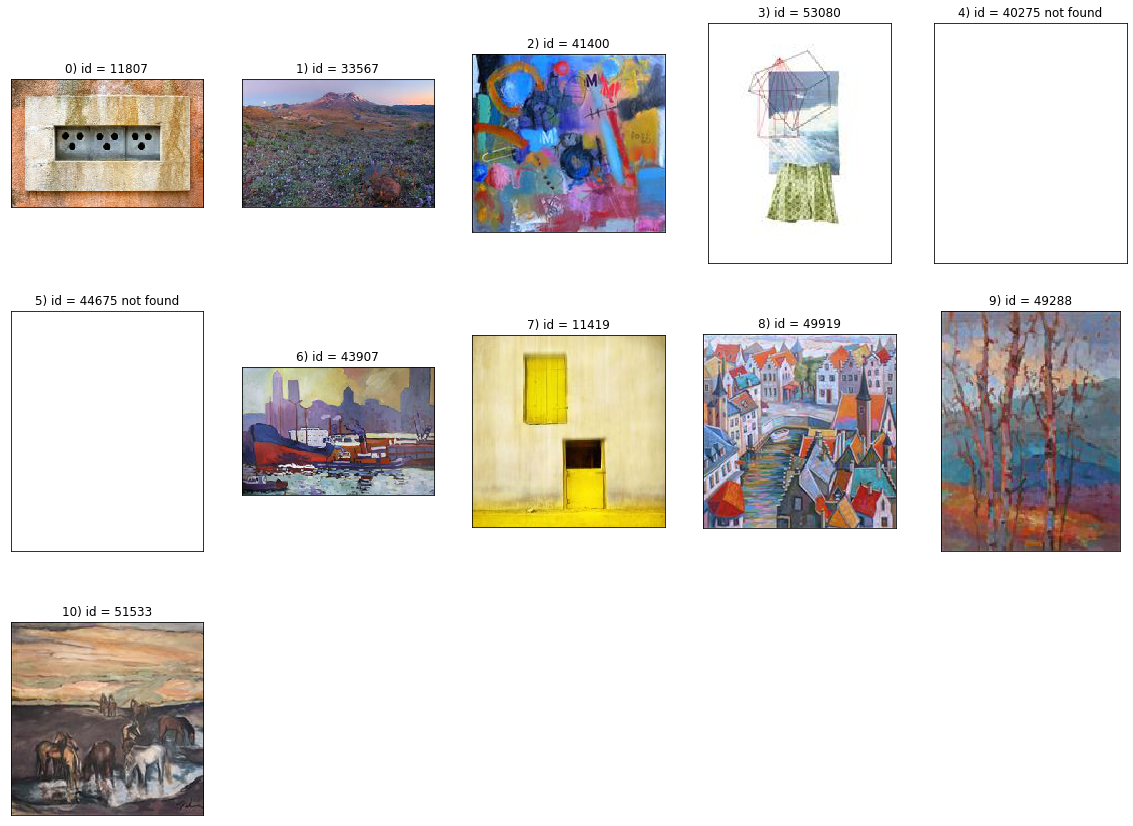




				============ Recommended items =============


unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/12855/Images/Medium_Branca.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/12855/Images/Medium_Branca.jpg


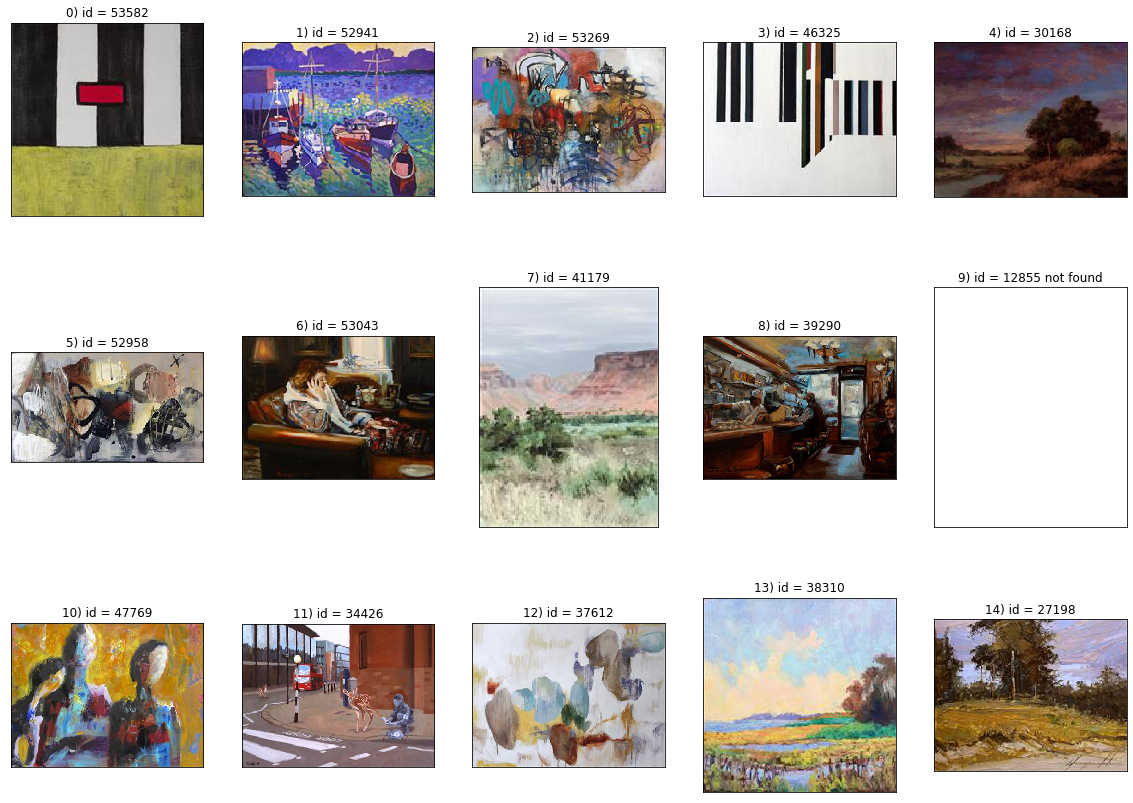

In [16]:
#rec = recommend(resnet50_featmat, user_id=8, topk=15)
#rec = recommend(vgg19_featmat, user_id=8, topk=15)
rec = recommend(pca20_resnet_vgg_hybrid_featmat, user_id=8, topk=15)

## **Pregunta 4** 

Basado en lo visto en clases indica 2 métricas que midan el rendimiento de nuestro modelo recomendador en este problema. ¿Cuáles son las ventajas y desventajas de cada uno?

**Respuesta 4**
Para esto se puede utilizar con el clásico nDCG y con Recall.

En el caso del primero, se contempla el orden de selección en la recomendación dentro de los n recomendados, entegando valor a este orden, a demás de la relevancia de los n ítems.

Recall mide la cantidad de True Positives respecto a los que realmente eran Positves (es decir, relevantes), por lo que nos da indicio de qué tan relevante fue la selección realizada. Sin embargo, solo da una métrica final, sin considerar el orden como en el caso anterior.

Claramente, el optimizar métricas implica desventajas en otros puntos, por ejemplo, en la diversificación o novedad, además de poder sesgar las respuestas en función de la ventaja de una métrica.

## **Pregunta 5** 

Genera nuevas recomendaciones mediante la función `recommend` cambiando el tipo de _embedding_ y la métrica de distancia para algún usuario. **Importante** puede ser que algunas imágenes ya no estén disponibles, no se asuste por eso.

**Respuesta 5**

user_id =  8
				============ Consumed items =============


unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/44675/Images/Medium_recliningnude.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/40275/Images/Medium_bakery_at_night_padaria_hopper.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/40275/Images/Medium_bakery_at_night_padaria_hopper.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/44675/Images/Medium_recliningnude.jpg


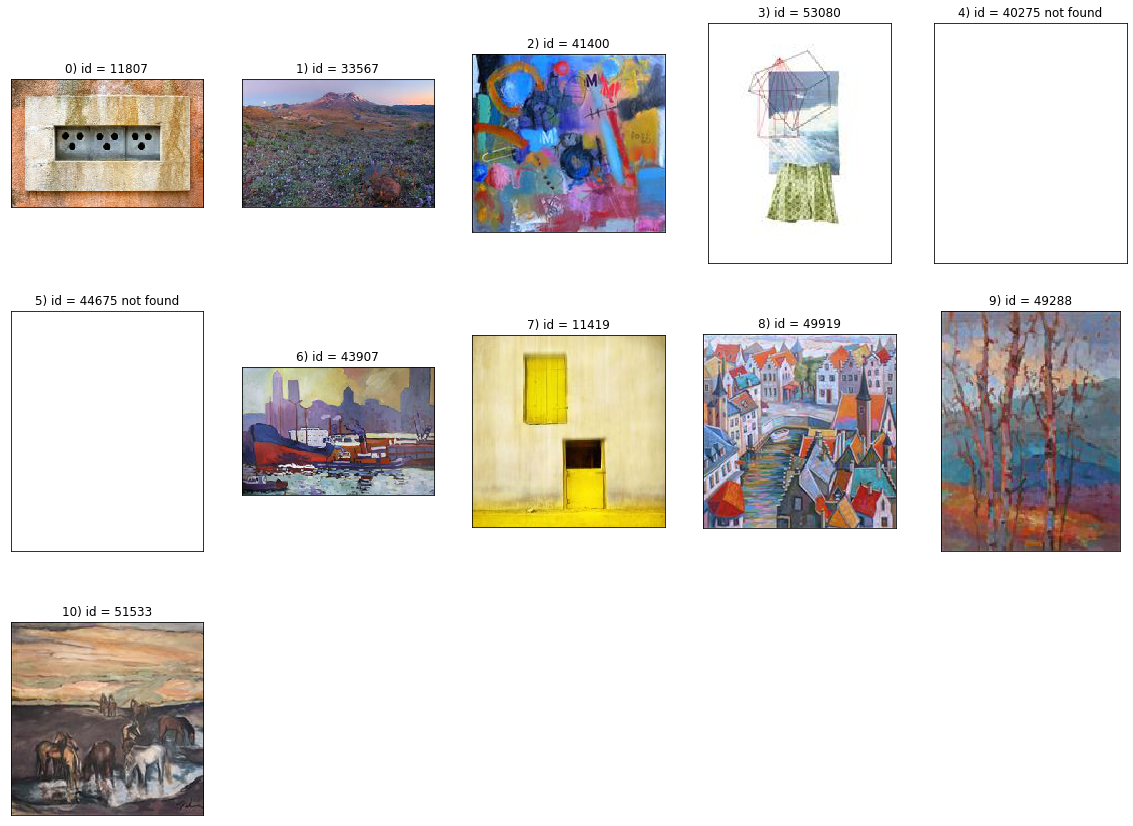




				============ Recommended items =============


unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/42754/Images/Medium_Coastal_Plain_40x40_Ugallery.jpg
unexpected r.status_code = 404 for url = http://static.ugallery.com/webdata/product/42754/Images/Medium_Coastal_Plain_40x40_Ugallery.jpg


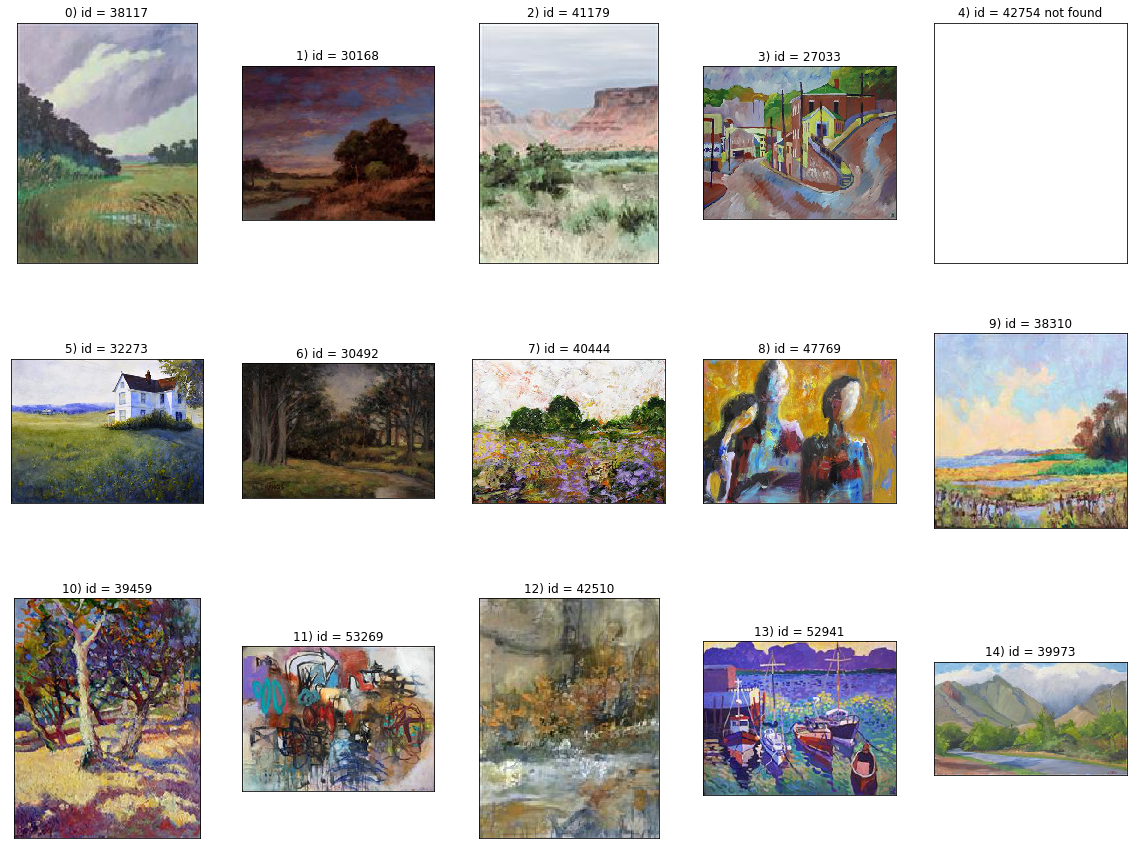

In [18]:
# Escribe tu codigo aquí

rec = recommend(resnet50_featmat, user_id=8, topk=15, metric="euclidean")